Please upload 'Customers.csv'


Saving Customers.csv to Customers.csv
Please upload 'Products.csv'


Saving Products.csv to Products.csv
Please upload 'Transactions.csv'


Saving Transactions.csv to Transactions.csv


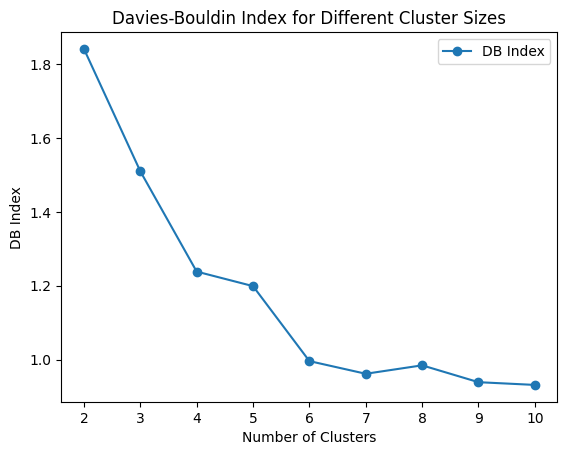

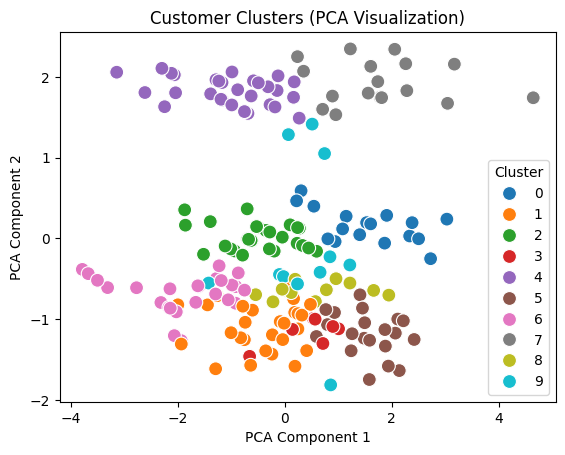


Clustering Summary:
   Cluster  total_customers  avg_total_spend  avg_purchase_frequency
0        0               19      5368.391579                7.631579
1        1               29      2371.090690                4.241379
2        2               28      2720.404286                4.392857
3        3                7      4681.601429                4.285714
4        4               30      2084.411667                3.633333
5        5               21      5153.887143                6.523810
6        6               25      1696.029200                3.160000
7        7               17      5786.858235                8.058824
8        8               12      4927.166667                6.666667
9        9               11      3602.241818                3.363636

Optimal number of clusters: 10
DB Index for optimal clustering: 0.931


In [1]:
#Task 3: Customer Segmentation / Clustering

# Required Libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("upload 'Customers.csv'")
uploaded = files.upload()
customers = pd.read_csv(next(iter(uploaded.keys())))

print("upload 'Products.csv'")
uploaded = files.upload()
products = pd.read_csv(next(iter(uploaded.keys())))

print("upload 'Transactions.csv'")
uploaded = files.upload()
transactions = pd.read_csv(next(iter(uploaded.keys())))
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, products, on='ProductID', how='left')
## Calculate total spend, average spend, and purchase frequency per customer
customer_features = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_spend=('TotalValue', 'mean'),
    purchase_frequency=('TransactionID', 'count')
).reset_index()
preferred_category = merged_data.groupby(['CustomerID', 'Category'])['TotalValue'].sum().reset_index()
preferred_category = preferred_category.loc[preferred_category.groupby('CustomerID')['TotalValue'].idxmax()]
preferred_category = preferred_category[['CustomerID', 'Category']]
data = pd.merge(customer_features, preferred_category, on='CustomerID', how='left')
data = pd.get_dummies(data, columns=['Category'], drop_first=True)

# Normalizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.iloc[:, 1:])

# Clustering using K-Means
cluster_results = []
db_index_values = []
silhouette_values = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)

    cluster_results.append((k, clusters, db_index))
    db_index_values.append(db_index)
    silhouette_values.append(silhouette_avg)
optimal_k = db_index_values.index(min(db_index_values)) + 2
optimal_clusters = cluster_results[optimal_k - 2][1]
data['Cluster'] = optimal_clusters
plt.plot(range(2, 11), db_index_values, marker='o', label='DB Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.title('Davies-Bouldin Index for Different Cluster Sizes')
plt.legend()
plt.show()

# PCA for Visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
data['PCA1'] = pca_features[:, 0]
data['PCA2'] = pca_features[:, 1]

sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
cluster_summary = data.groupby('Cluster').agg(
    total_customers=('CustomerID', 'count'),
    avg_total_spend=('total_spend', 'mean'),
    avg_purchase_frequency=('purchase_frequency', 'mean')
).reset_index()

print("\nClustering Summary:")
print(cluster_summary)

print(f"\nOptimal number of clusters: {optimal_k}")
print(f"DB Index for optimal clustering: {min(db_index_values):.3f}")
